In [217]:
# Basic Imports
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import os

# Personal Function Imports
from env import get_db_url
import acquire as a
import prepare as p
import explore as e
import model as m



# Stats and ML Imports
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree


Planning Phase

https://docs.google.com/document/d/10vhT5G70x_BJ0-5FftQxdrXH2cqgBsJDrmYP_zP5KnY/edit?usp=sharing

Acquire Phase

In [218]:
def get_telco_data():
    
    '''
    
    This function retrieves data from the 'customers' table in the 'telco_churn' database, and joins it with the 'contract_types', 'internet_service_types', and 'payment_types' tables. The resulting dataframe contains information about customers' contracts, internet service types, payment types, and other relevant information.
    
    '''
    
    filename = "churn.csv"
        
    if os.path.isfile(filename):
        return pd.read_csv(filename, index_col=0)

    else:
        url = get_db_url('telco_churn')
        df_telco_churn = pd.read_sql(('''
        SELECT * From customers
        join contract_types
            using (contract_type_id)
        join internet_service_types
            using(internet_service_type_id)
        join payment_types
            using(payment_type_id)'''), url)
        df_telco_churn.to_csv(filename)
    return df_telco_churn   

In [219]:
df=get_telco_data()
df.head()


,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check
1,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
2,1,2,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Fiber optic,Mailed check


Initial Examination of Data

In [63]:
df.shape

(7043, 24)

In [64]:
df.isnull().sum()

payment_type_id                0
internet_service_type_id       0
contract_type_id               0
customer_id                    0
gender                         0
senior_citizen                 0
partner                        0
dependents                     0
tenure                         0
phone_service                  0
multiple_lines                 0
online_security                0
online_backup                  0
device_protection              0
tech_support                   0
streaming_tv                   0
streaming_movies               0
paperless_billing              0
monthly_charges                0
total_charges                  0
churn                          0
contract_type                  0
internet_service_type       1526
payment_type                   0
dtype: int64

In [65]:
df.describe()

,payment_type_id,internet_service_type_id,contract_type_id,senior_citizen,tenure,monthly_charges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,2.315633,1.872923,1.690473,0.162147,32.371149,64.761692
std,1.148907,0.737796,0.833755,0.368612,24.559481,30.090047
min,1.000000,1.000000,1.000000,0.000000,0.000000,18.250000
25%,1.000000,1.000000,1.000000,0.000000,9.000000,35.500000
50%,2.000000,2.000000,1.000000,0.000000,29.000000,70.350000
75%,3.000000,2.000000,2.000000,0.000000,55.000000,89.850000
max,4.000000,3.000000,3.000000,1.000000,72.000000,118.750000


In [66]:
df.dtypes

payment_type_id               int64
internet_service_type_id      int64
contract_type_id              int64
customer_id                  object
gender                       object
senior_citizen                int64
partner                      object
dependents                   object
tenure                        int64
phone_service                object
multiple_lines               object
online_security              object
online_backup                object
device_protection            object
tech_support                 object
streaming_tv                 object
streaming_movies             object
paperless_billing            object
monthly_charges             float64
total_charges                object
churn                        object
contract_type                object
internet_service_type        object
payment_type                 object
dtype: object

Takeaways: Internet Service Type has nulls that need to be taken care of, total charges need to convert to float,
type_id columns need dropped due to corresponding factor columns. 

Prep Phase

In [67]:
# initial prep for exploration based on known conditions
def prep_telco():
    
    '''
    
    This function calls the acquire function to get the telco data.  Then drops type_id columns with corresponding 
    factors. Nulls are filled in. Total charges converted from object to float and nulls/nan filled in
    
    '''
    df_telco_churn = a.get_telco_data()
    
    # drop type_id columns due to corresponding factor columns
    df_telco_churn=df_telco_churn.drop(
        columns= [
        'payment_type_id','internet_service_type_id','contract_type_id'
        ],errors='ignore'
    )
    
    # fill Internet service type Nulls
    df_telco_churn['internet_service_type'].fillna("No internet service", inplace=True)
    
    # total charges is detected as an object, but holds mainly numbers. use pd.to_numeric() to force everything to 
    # a number, and anything that it cannot convert, we'll make it Null and investigate those.
    df_telco_churn['total_charges'] = pd.to_numeric(
        df_telco_churn['total_charges'], errors='coerce'
    )
    
    # Total charges = 0 also has Tenure = 0. Assumption: they're new and haven't been charged
    df_telco_churn['total_charges'].fillna(0, inplace=True)
    
    
    # shorten payment type categories for graphing
    df_telco_churn["payment_type"].replace(
        {
            "Electronic check": "electronic check",
            "Mailed check": "mailed check",
            "Credit card (automatic)": "credit card",
            "Bank transfer (automatic)": "bank transfer",
        },
        inplace=True,
    )

    return df_telco_churn

In [68]:
df=prep_telco()
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,No,Yes,...,Yes,Yes,No,Yes,65.6,593.30,No,One year,DSL,mailed check
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,No,No,...,No,No,Yes,No,59.9,542.40,No,Month-to-month,DSL,mailed check
2,0004-TLHLJ,Male,0,No,No,4,Yes,No,No,No,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,electronic check
3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,No,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,electronic check
4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,No,No,...,Yes,Yes,No,Yes,83.9,267.40,Yes,Month-to-month,Fiber optic,mailed check


In [69]:
df.isnull().sum()

customer_id              0
gender                   0
senior_citizen           0
partner                  0
dependents               0
tenure                   0
phone_service            0
multiple_lines           0
online_security          0
online_backup            0
device_protection        0
tech_support             0
streaming_tv             0
streaming_movies         0
paperless_billing        0
monthly_charges          0
total_charges            0
churn                    0
contract_type            0
internet_service_type    0
payment_type             0
dtype: int64

In [70]:
df.dtypes

customer_id               object
gender                    object
senior_citizen             int64
partner                   object
dependents                object
tenure                     int64
phone_service             object
multiple_lines            object
online_security           object
online_backup             object
device_protection         object
tech_support              object
streaming_tv              object
streaming_movies          object
paperless_billing         object
monthly_charges          float64
total_charges            float64
churn                     object
contract_type             object
internet_service_type     object
payment_type              object
dtype: object

In [71]:
df.shape

(7043, 21)

In [72]:
df.describe()

,senior_citizen,tenure,monthly_charges,total_charges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


Simple Visuals for More Easily Digestible Data (Univariate Analysis)

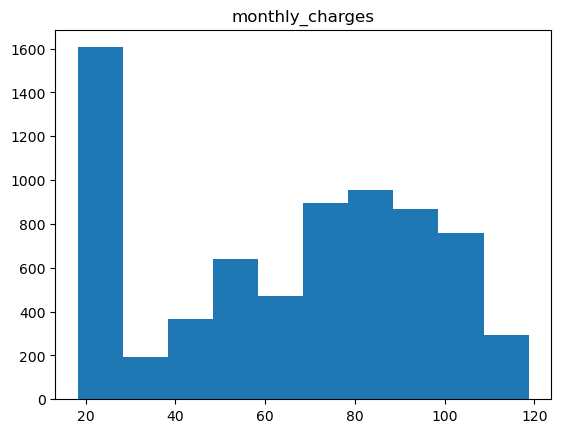

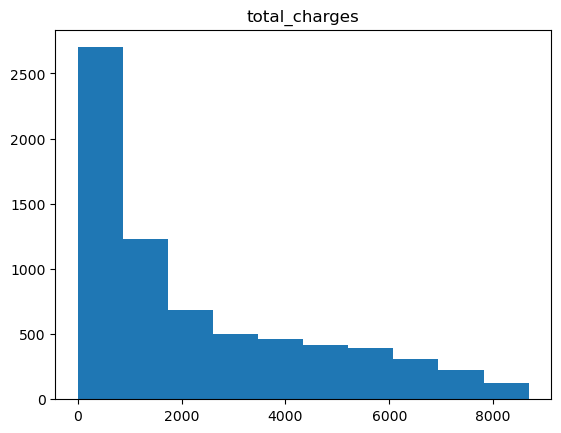

In [73]:
# distributions of float data
num_cols = df.columns[[df[col].dtype == 'float64' for col in df.columns]]
for col in num_cols:
    plt.hist(df[col])
    plt.title(col)
    plt.show()

Takeaways: 

Total charges are just a function of monthly charges and tenure.  It has been decided to omit tenure 
(reasoning below).  Total Charges will also be omitted due to its function relationship.  Affordability is a likely
a key factor in consumer spending.  

Question:  Is monthly charges a statistically significant indicator of churn? 

Data assumption: Montly charges have a high correlation to contract type.  

Question: Does contract type or monthly charge have a higher relationship to churn?

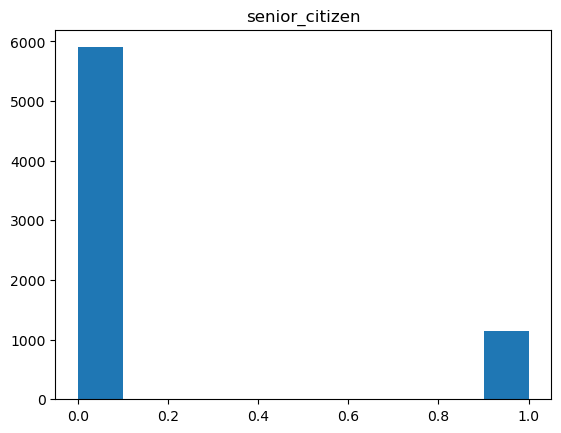

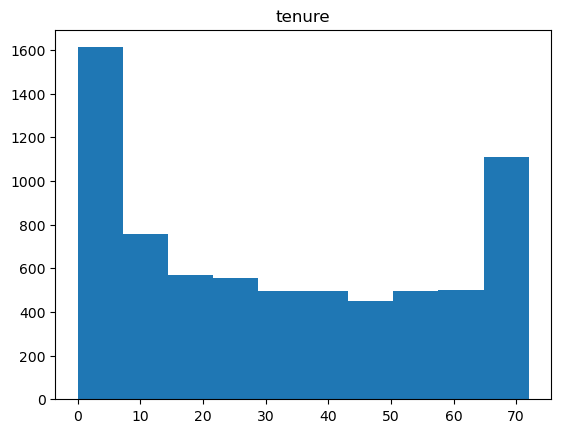

In [74]:
# Check out distributions of int data.

num_cols = df.columns[[df[col].dtype == 'int64' for col in df.columns]]
for col in num_cols:
    plt.hist(df[col])
    plt.title(col)
    plt.show()


Takeaways:  

Senior citizen seems to be a neglibible contributor to churn and will be omitted from intial exploration.  
Tenure has a fairly uniform distribution from around 15 to 60 months.  Knowing tenures relationship to churn does not help us identify the driver of churn.  Once the drivers of churn are identified, it would be beneficial to see how those drivers relate to tenure.  For the purposes of this project Tenure will be omitted. 

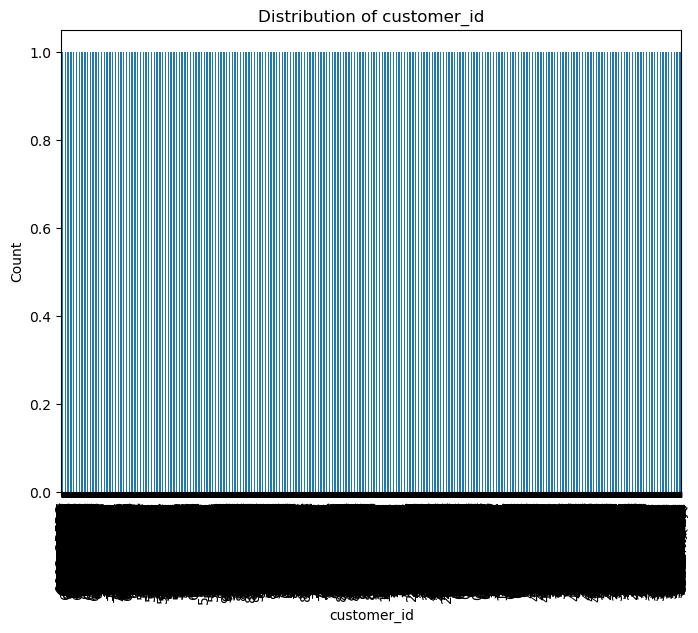

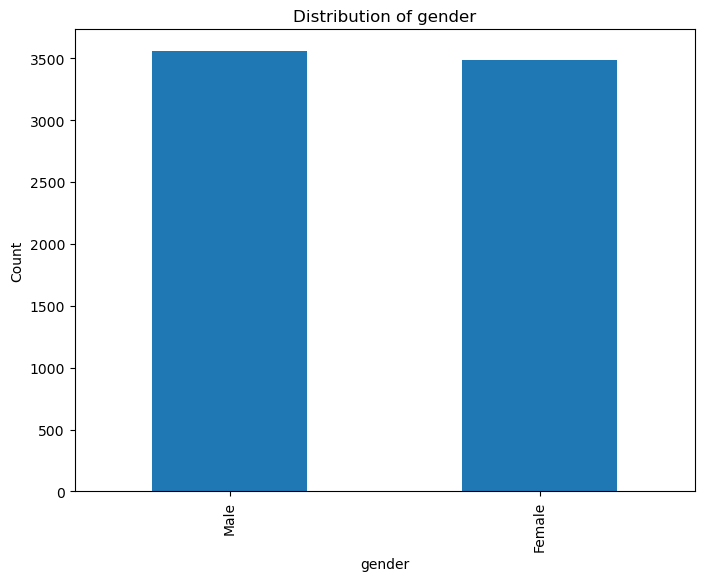

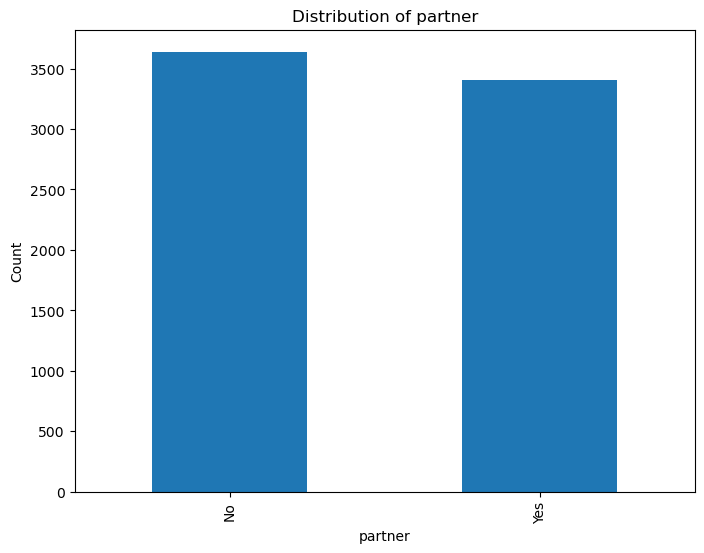

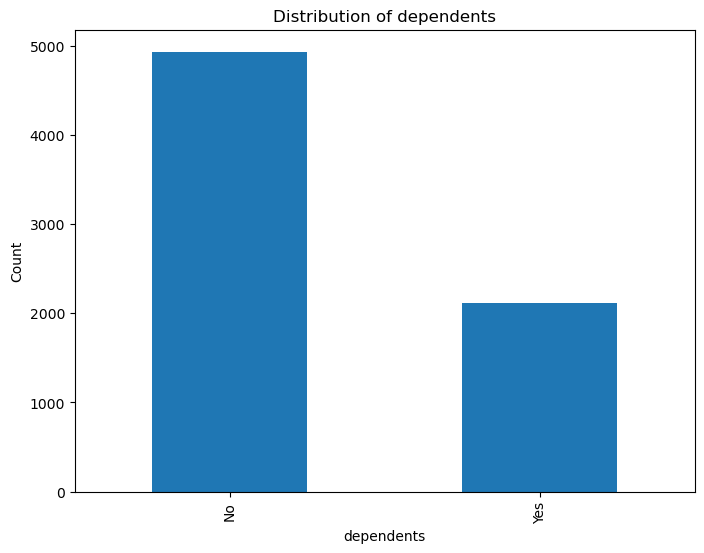

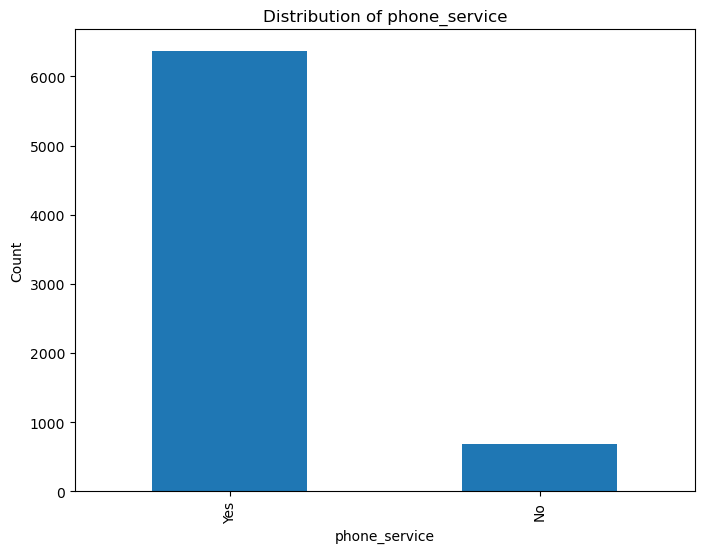

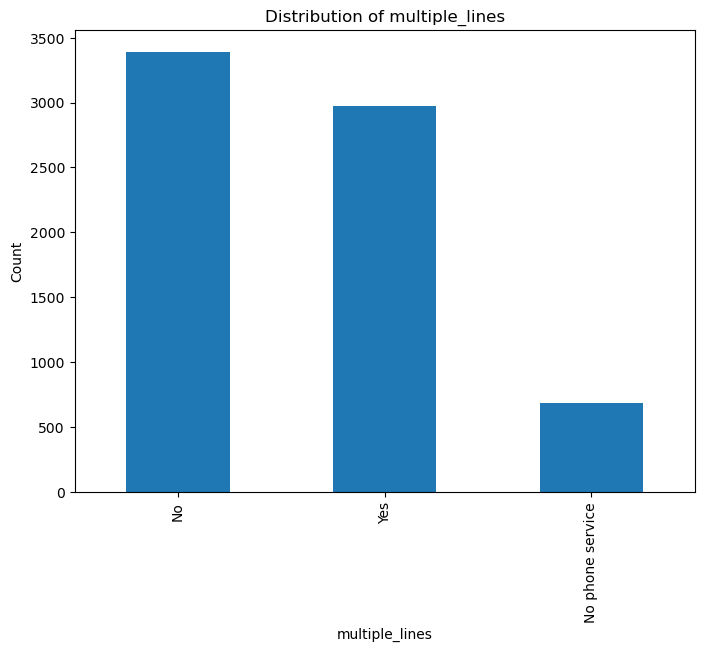

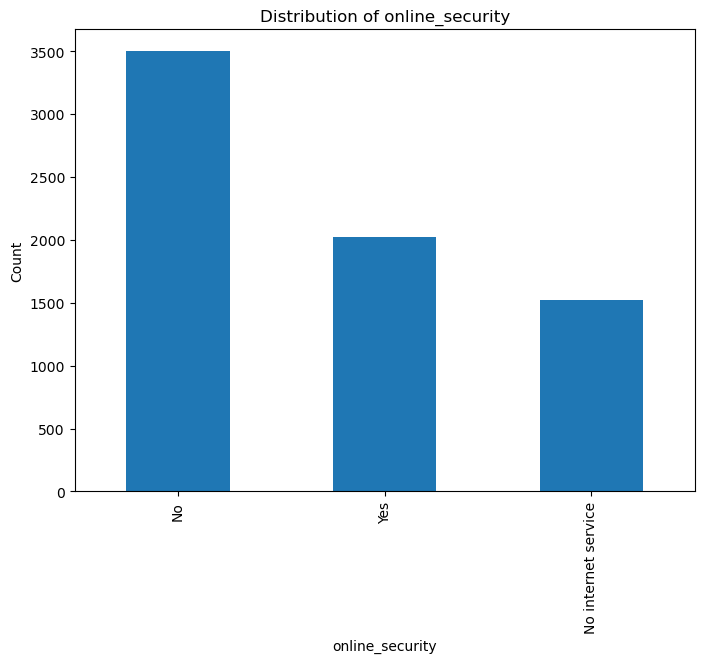

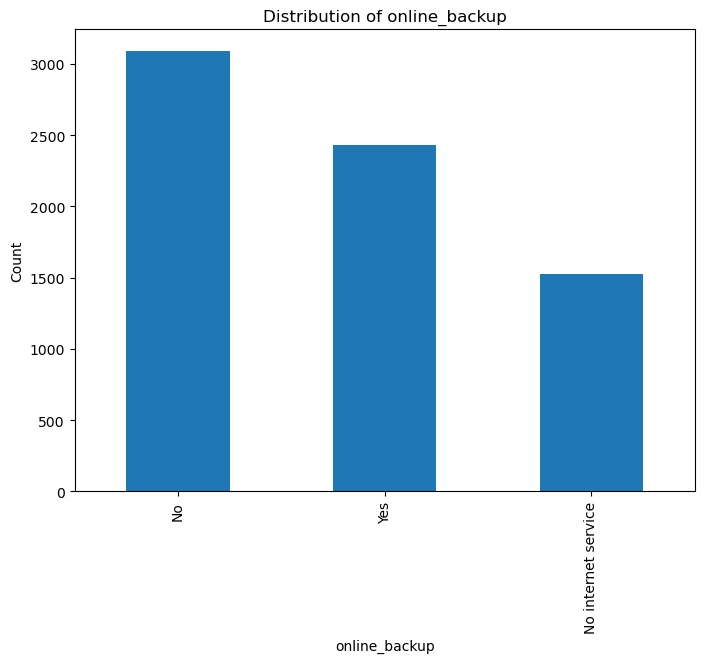

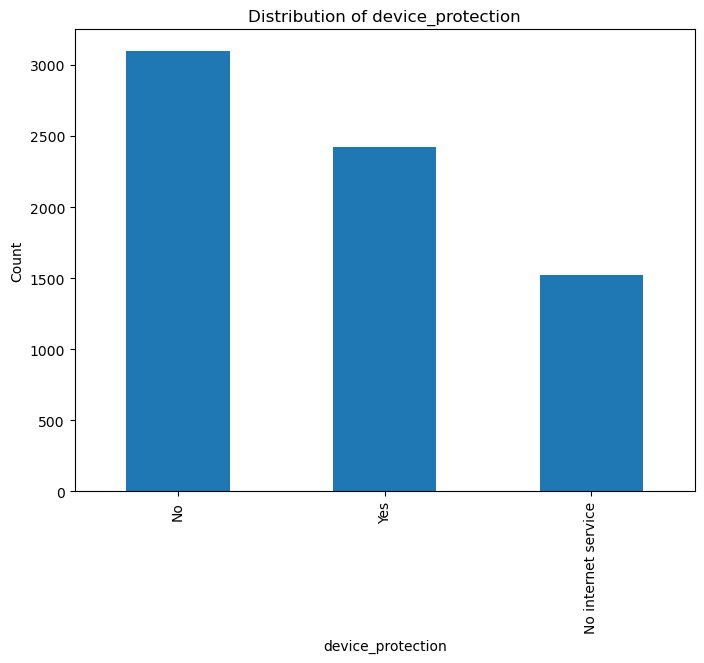

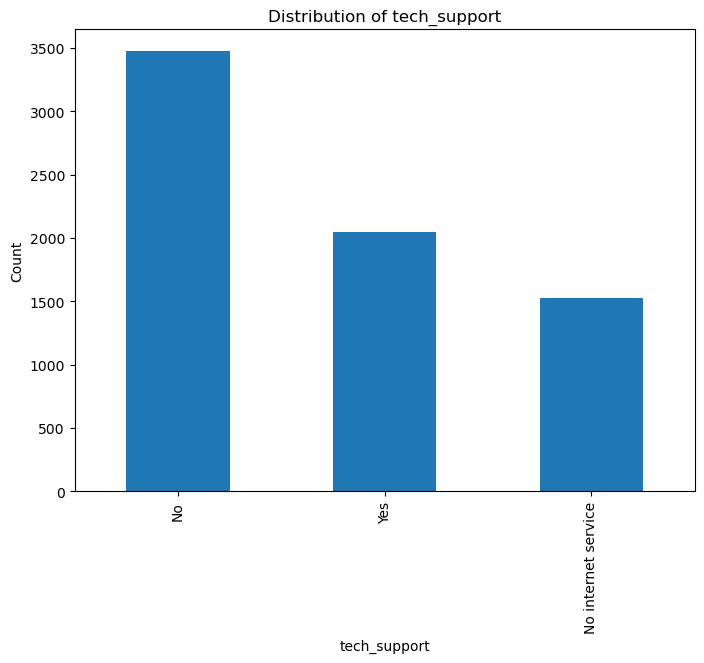

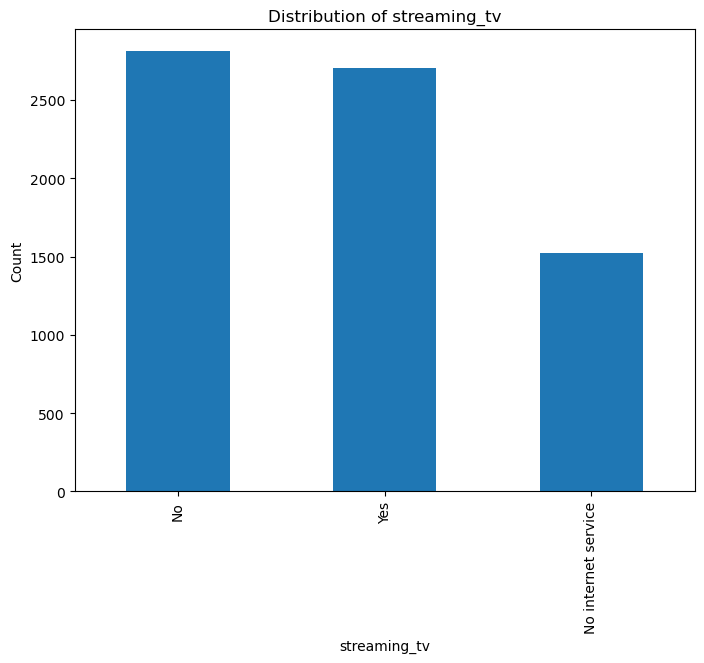

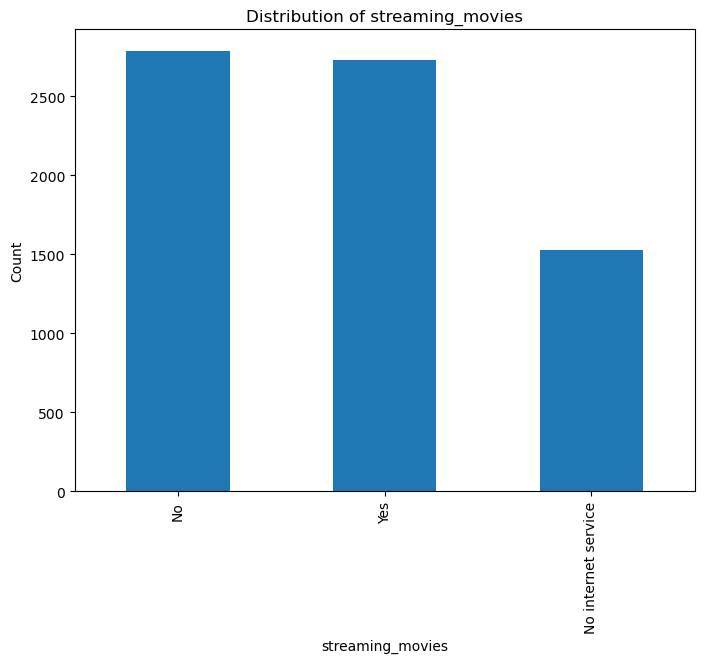

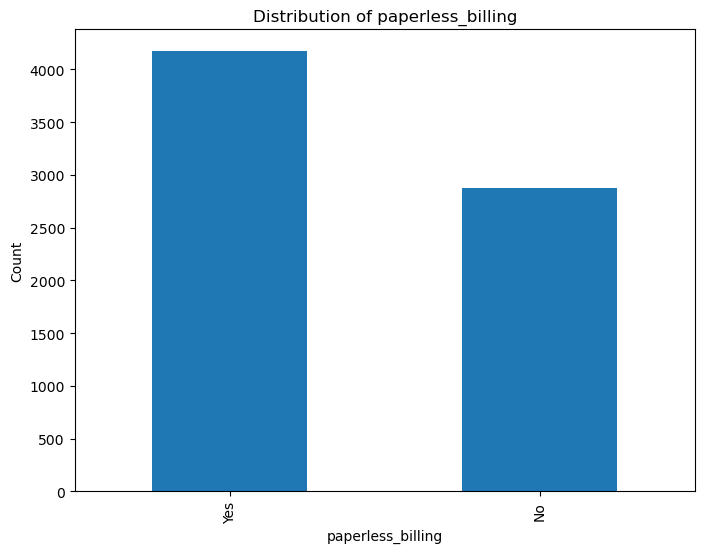

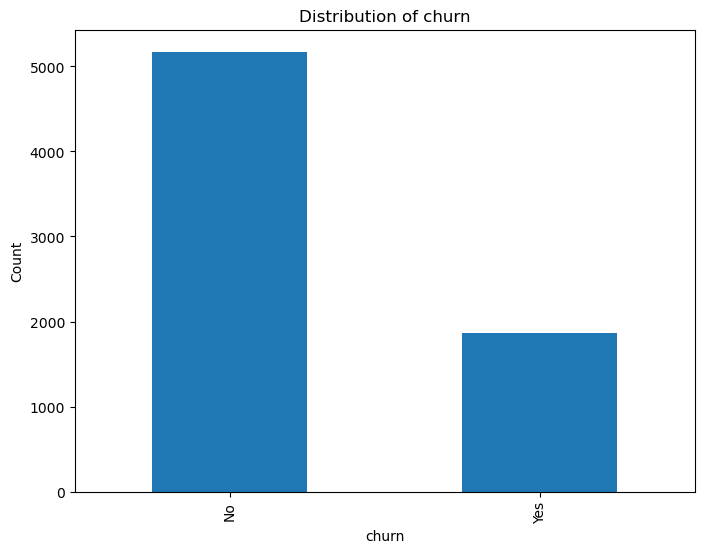

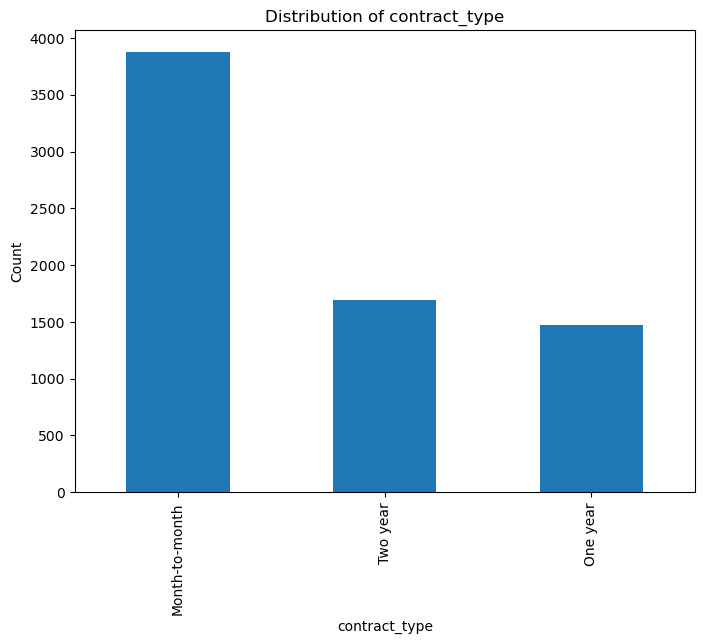

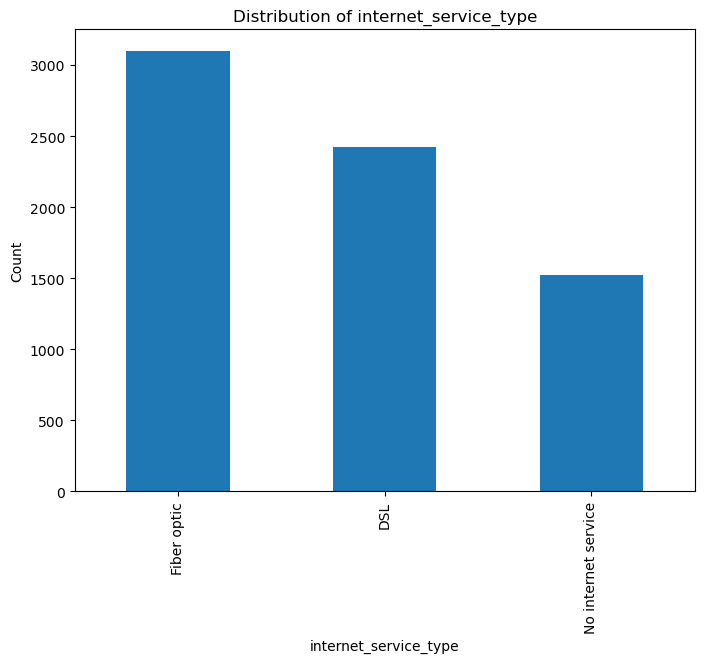

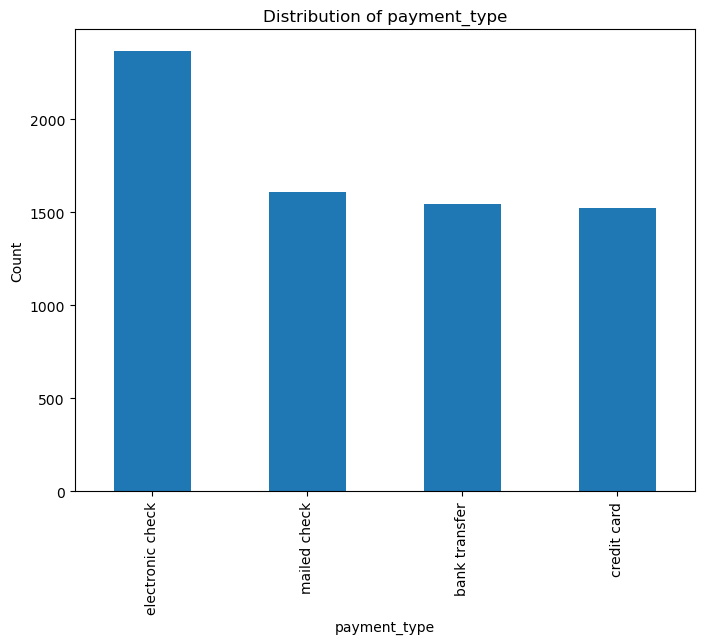

In [75]:

# Select columns with 'object' dtype
num_cols = df.columns[df.dtypes == 'object']


# Iterate through categorical columns and create bar plots
for col in num_cols:

    plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()


Takeaways: 
    
gender and partner are almost equal and not a likely contributors to churn columns will be omitted from initial
exploration, dependents also not a likely contributor and will also be omitted. Only a small number of customers do 
not have phone service.  This column and multiple lines will be dropped. Online security, online backup, device protection, 
streaming movies, streaming tv, and tech support are all indicative of services that stem from internet service type
so all these categories will be omitted and considered for further evaluation upon inital results. Paperless billing
is fairly even and that consumer preference is not likely to have a bearing on churn.  This will be omitted

In [76]:
def split_data(df, target_column):
    '''

    Splits a DataFrame into training, validation, and test sets, stratifying on the 'churn' variable.
   
    '''
    train, validate_test = train_test_split(df,
                                            train_size=0.60,
                                            random_state=123,
                                            stratify=df[target_column])

 
    validate, test = train_test_split(validate_test,
                                      test_size=0.50,
                                      random_state=123,
                                      stratify=validate_test[target_column])

    return train, validate, test



In [77]:
train, validate, test=split_data(df, 'churn')

In [78]:
train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
2865,4083-BFNYK,Female,1,Yes,No,38,Yes,Yes,Yes,Yes,...,No,No,Yes,No,95.00,3591.25,No,One year,Fiber optic,credit card
4107,5804-LEPIM,Female,1,No,No,2,Yes,No,No,No,...,No,No,No,Yes,70.35,139.05,Yes,Month-to-month,Fiber optic,electronic check
3453,4895-TMWIR,Male,1,Yes,No,11,Yes,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,No,19.95,214.75,Yes,Month-to-month,No internet service,mailed check
923,1342-JPNKI,Male,0,No,No,10,Yes,Yes,No,No,...,No,Yes,No,Yes,86.05,834.10,Yes,Month-to-month,Fiber optic,bank transfer
2370,3397-AVTKU,Male,0,No,No,43,Yes,No,No,Yes,...,No,No,Yes,Yes,60.00,2548.55,No,Two year,DSL,electronic check


In [79]:
train.shape

(4225, 21)

In [80]:
validate.shape

(1409, 21)

In [81]:
test.shape

(1409, 21)

Exploratory Phase

Initial Hypothesis: Customers churn due to affordability, lack of speed of service, and inconvenience

Features that most closely relate to these churn categories and will be evaluated are monthly charges, internet service type, contract type, and payment type.  


Internet Service Type, contract type, and payment type are categorical variables.  Use Chi 2 test to evaluate statistical signifgance and create visuals

Null Hypthosesis:  There is no relationship between the target variable and corresponding feature(s)\
Hypothesis: there is a relationship betweent the target variable and corresponding feature(s)

In [82]:
def explore_categorical(train, target, cat_var, alpha=0.05):
    '''
    Explore the relationship between a binary target variable and a categorical variable.

    Parameters:
    train: The training data split set.
    target (str): The name of the binary target variable.
    cat_var (str): The name of the categorical variable to explore.
    alpha (float): Significance level for hypothesis testing.

    '''
    # Print the name of the categorical variable
    print()
    print(cat_var, "&", target)
    print("")

    # Calculate the chi-squared test statistic, p-value, degrees of freedom, and expected values
    ct = pd.crosstab(train[cat_var], train[target], margins=True)
    chi2, p, dof, expected = stats.chi2_contingency(ct)
    print(f"Chi2: {chi2}")
    print(f"P-value: {p}")
    print(f"Degrees of Freedom: {dof}")

    # Create a count plot of the categorical variable split by the target variable
    sns.catplot(x=cat_var, hue=target, data=train, kind="count")

    # Show the plot
    plt.title(f"{cat_var} by {target}")
    plt.show()

    # Check for statistical significance
    if p < alpha:
        print("The null hypothesis can be rejected due to statistical significance.")
    else:
        print("The null hypothesis cannot be rejected at the chosen significance level.")


internet_service_type & churn

Chi2: 417.88813854093104
P-value: 3.9804371258943206e-87
Degrees of Freedom: 6


/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


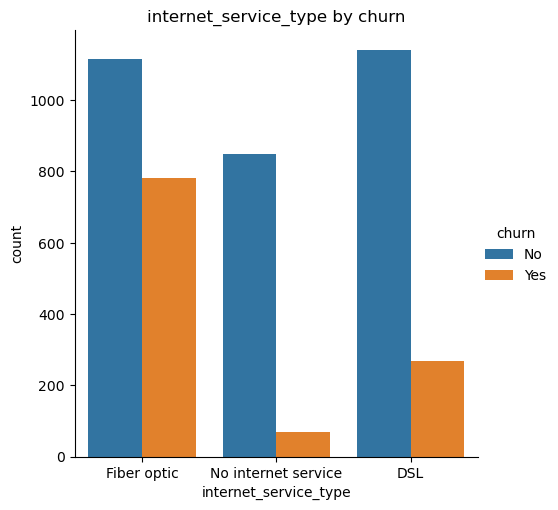

The null hypothesis can be rejected due to statistical significance.

payment_type & churn

Chi2: 386.1839951483273
P-value: 1.687008595564822e-78
Degrees of Freedom: 8


/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


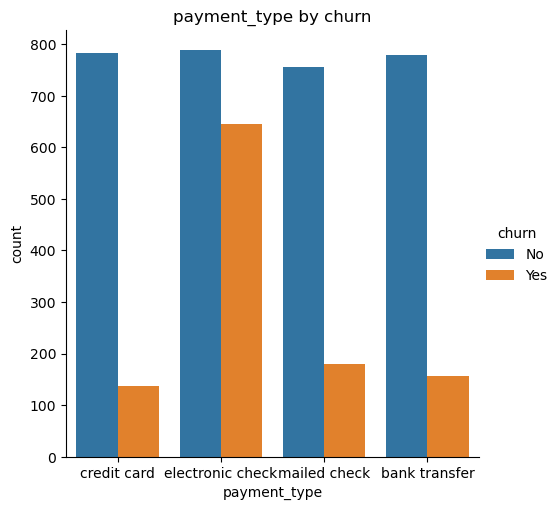

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


The null hypothesis can be rejected due to statistical significance.

contract_type & churn

Chi2: 714.1745080997528
P-value: 5.320189784717562e-151
Degrees of Freedom: 6


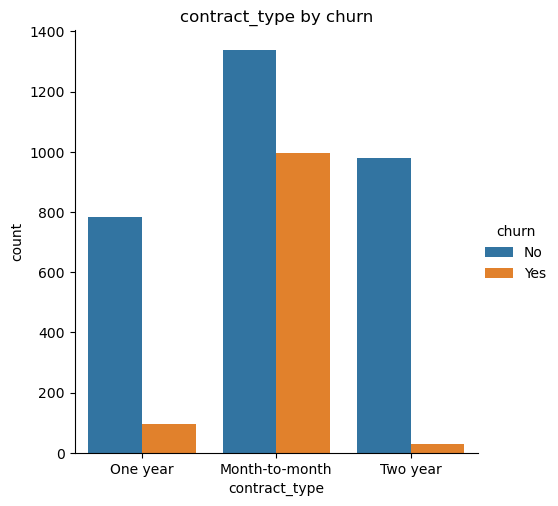

The null hypothesis can be rejected due to statistical significance.


In [83]:
# create categories variable with object type for 
categories = ['internet_service_type', 'payment_type', 'contract_type']

for cat_var in categories:
    explore_categorical(train, 'churn', cat_var)

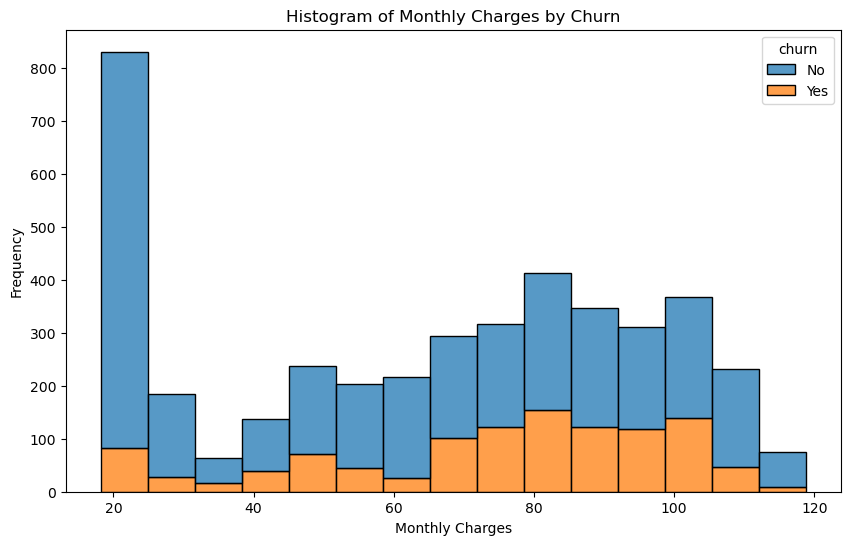

In [84]:
# # revisualize monthly charges to guide exploration
# plt.hist(train['monthly_charges'])
# plt.title('Histogram of Monthly Charges')
# plt.xlabel('Monthly Charges')
# plt.ylabel('Frequency')
# plt.show()

# Histgram needed to show more data in relation to churn

# adjusted size for easier viewing
plt.figure(figsize=(10, 6))
sns.histplot(data=train, x='monthly_charges', hue='churn', multiple='stack')
plt.title('Histogram of Monthly Charges by Churn')
plt.xlabel('Monthly Charges')
plt.ylabel('Frequency')
plt.show()

Graph indicates there is a statistical difference between the distribution of churn in relation to monthly charges.  Monthly charges is a continuous variable and churn is currently a categorical variable.  Sample size > 30 so normalcy can be assumed.  However, monthly charges have a significant amount of outliers.  Will run Levene and Shapiro for equal variance and normality testing to decide t-test or mann whitney U test. 

In [85]:
# set alpha
α=.05

# Hypothesis for Levene
# Null: variances are equal
# Alt: No equal variance

# Hypothesis for Shapiro
# Null:  Data follows normal distributon
# Alt: Data does not follow normal distribution


# need two groups of data from the train data to test.  Split by even and odd rows
group1 = train.monthly_charges[train.index % 2 == 0]
group2 = train.monthly_charges[train.index % 2 != 0]

# Calculate the Levene test and Shapiro test
levene_test_statistic, levene_test_pvalue = stats.levene(group1, group2)

statistic_shapiro, p_value_shapiro = stats.shapiro(train.monthly_charges)

# Print the results
print('Levene T Stat:', levene_test_statistic)
print('Levene P Value:', levene_test_pvalue)
if levene_test_pvalue < α:
    print(f'Reject Null, accept no equal variance')
else:
    print(f'Reject Alternative, accept variances are equal')
print()

print('Shapiro T Stat:', statistic_shapiro)
print('Shapiro P Value:', p_value_shapiro)
if p_value_shapiro<α:
    print('Reject Null, accept data does not follow a normal distribution')
else:
    print('Reject Alt, accept data does follow a normal distribution')

Levene T Stat: 3.100680158285355
Levene P Value: 0.07833195873984876
Reject Alternative, accept variances are equal

Shapiro T Stat: 0.9185670018196106
Shapiro P Value: 5.647232811229013e-43
Reject Null, accept data does not follow a normal distribution


Run Mann whitney U test 

In [86]:
# Create two groups based on churn status
group_not_churn = train.monthly_charges[train.churn == 'No']
group_churn = train.monthly_charges[train.churn == 'Yes']

# Perform Mann-Whitney U test
u_statistic, mannwhitney_pvalue = stats.mannwhitneyu(group_not_churn, group_churn)

# Print the results
print('Mann-Whitney U statistic:', u_statistic)
print('Mann-Whitney U test p-value:', mannwhitney_pvalue)

# Interpret the results
α = 0.05
if mannwhitney_pvalue < α:
    print('There is a significant difference in monthly charges between churn and non-churn groups.')
else:
    print('There is no significant difference in monthly charges between churn and non-churn groups.')


Mann-Whitney U statistic: 1343343.0
Mann-Whitney U test p-value: 9.83259830397179e-30
There is a significant difference in monthly charges between churn and non-churn groups.


consolidate graphs for final report

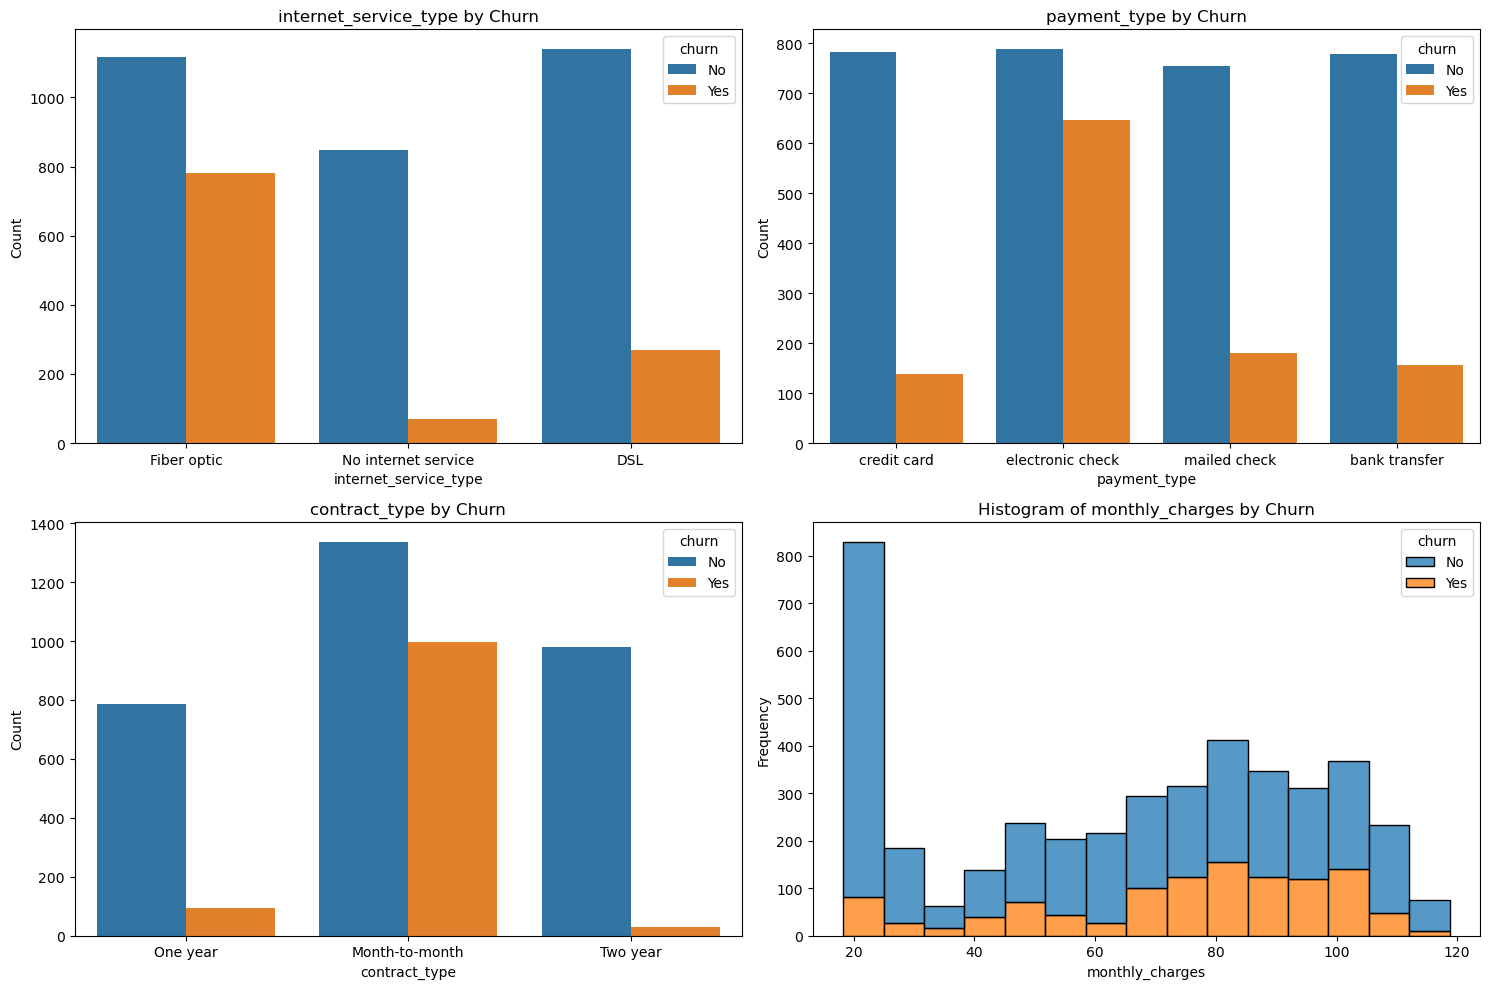

In [87]:
categories = ['internet_service_type', 'payment_type', 'contract_type', 'monthly_charges']

# Set up the subplot grid
num_cols = 2  # Number of columns in the subplot grid
num_rows = (len(categories) + 1) // num_cols  # Calculate the number of rows

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Iterate through categories and create count plots or stacked histograms
for i, category in enumerate(categories):
    if train[category].dtype == 'object':
        sns.countplot(x=category, hue='churn', data=train, ax=axes[i])
        axes[i].set_title(f'{category} by Churn')
        axes[i].set_xlabel(category)
        axes[i].set_ylabel('Count')
    else:
        sns.histplot(data=train, x=category, hue='churn', multiple='stack', ax=axes[i])
        axes[i].set_title(f'Histogram of {category} by Churn')
        axes[i].set_xlabel(category)
        axes[i].set_ylabel('Frequency')

# Adjust layout for better appearance
plt.tight_layout()
plt.show()

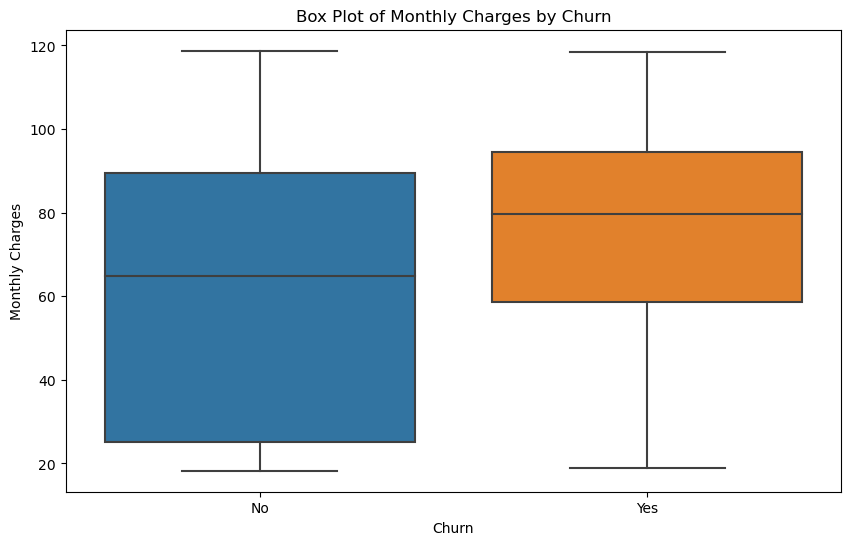

In [88]:
# Don't like what I am seeing for the monthly charge histogram.  Feel like there is a better way to understand the data because a lot less customers
# churn than don't churn.  

# course of action taken use box plot visualizaiton

# box plot better to reveal more info
plt.figure(figsize=(10, 6))
sns.boxplot(x='churn', y='monthly_charges', data=train)
plt.title('Box Plot of Monthly Charges by Churn')
plt.xlabel('Churn')
plt.ylabel('Monthly Charges')
plt.show()




Observations: means are different
Q1: Is central tendency (medians) different?  Can use mannwhitney to test statistical difference of medians?
Q2: Affordability tends to be a driver in many consumer decisions how can I see the impact of monthly charge affordability across other featurs?

In [89]:
# A1:
median_not_churn = group_not_churn.median()
median_churn = group_churn.median()
print(f'Median of non churn:', median_not_churn)
print(f'Median of churn:', median_churn)

Median of non churn: 64.85
Median of churn: 79.65


In [90]:
# A1(a):
# Null: Medians are equal
# Alt: Medians are not equal

# Perform Mann-Whitney U test
u_statistic, mannwhitney_pvalue = stats.mannwhitneyu(median_not_churn, median_churn)

# Print the results
print('Mann-Whitney U statistic:', u_statistic)
print('Mann-Whitney U test p-value:', mannwhitney_pvalue)

# Interpret the results
α = 0.05
if mannwhitney_pvalue < α:
    print('Median monthly charges between churn and non-churn groups are equal')
else:
    print('Mediann monthly charges between churn and non-churn groups are not equal.')

Mann-Whitney U statistic: 0.0
Mann-Whitney U test p-value: 1.0
Mediann monthly charges between churn and non-churn groups are not equal.


A2: Subgroup Analysis

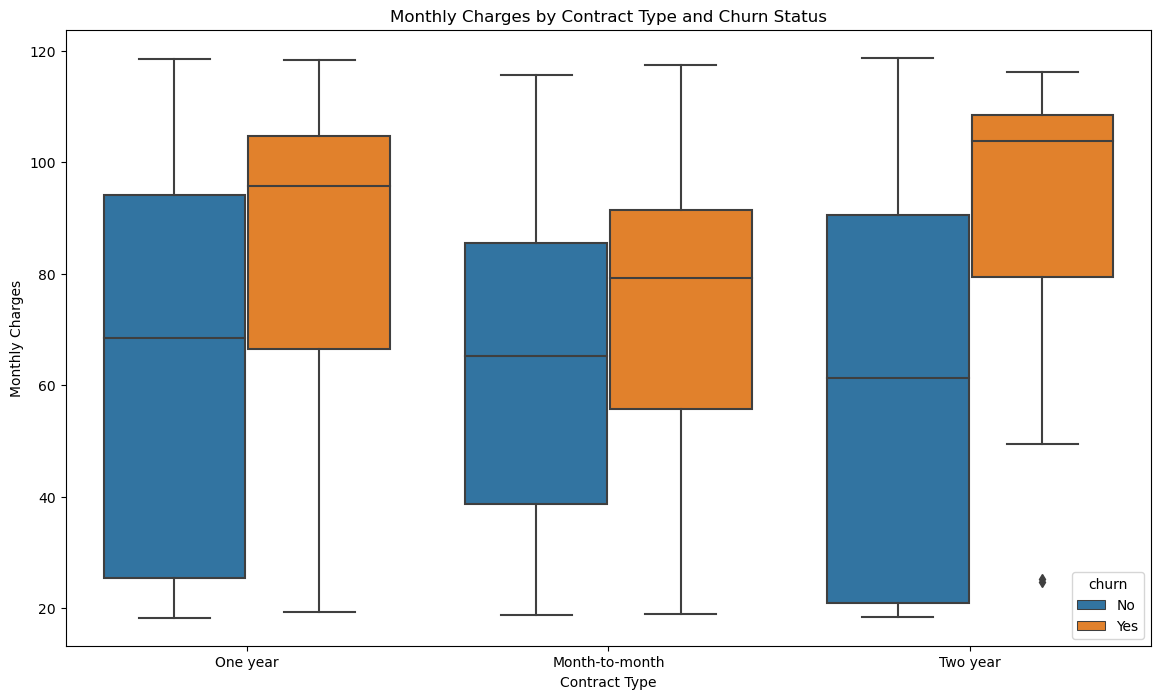

In [91]:
# Create subsets for each combination of contract type and internet service type
subgroups = train.groupby(['contract_type', 'internet_service_type'])

# Visualize the mean monthly charges with hue for churn status using a point plot
plt.figure(figsize=(14, 8))
sns.boxplot(x='contract_type', y='monthly_charges', hue='churn', data=train)
plt.title('Monthly Charges by Contract Type and Churn Status')
plt.xlabel('Contract Type')
plt.ylabel('Monthly Charges')
plt.show()


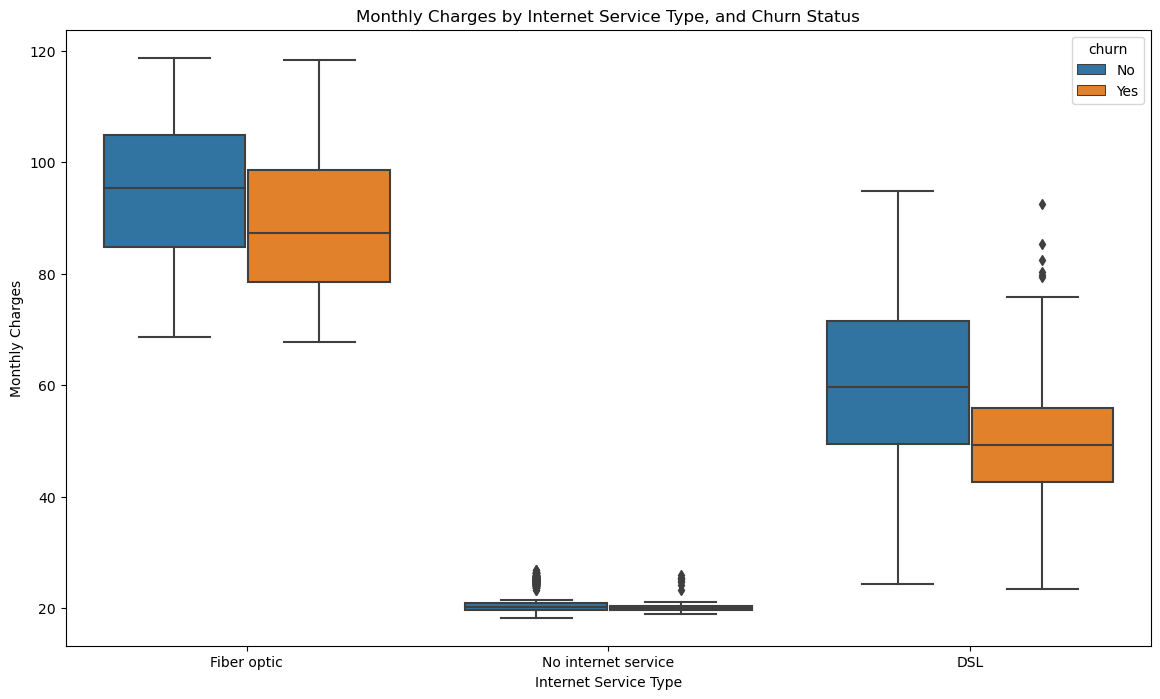

In [92]:
# Create subsets for each combination of contract type and internet service type
subgroups = train.groupby(['contract_type', 'internet_service_type'])

# Visualize the mean monthly charges with hue for churn status using a point plot
plt.figure(figsize=(14, 8))
sns.boxplot(x='internet_service_type', y='monthly_charges', hue='churn', data=train)
plt.title('Monthly Charges by Internet Service Type, and Churn Status')
plt.xlabel('Internet Service Type')
plt.ylabel('Monthly Charges')
plt.show()

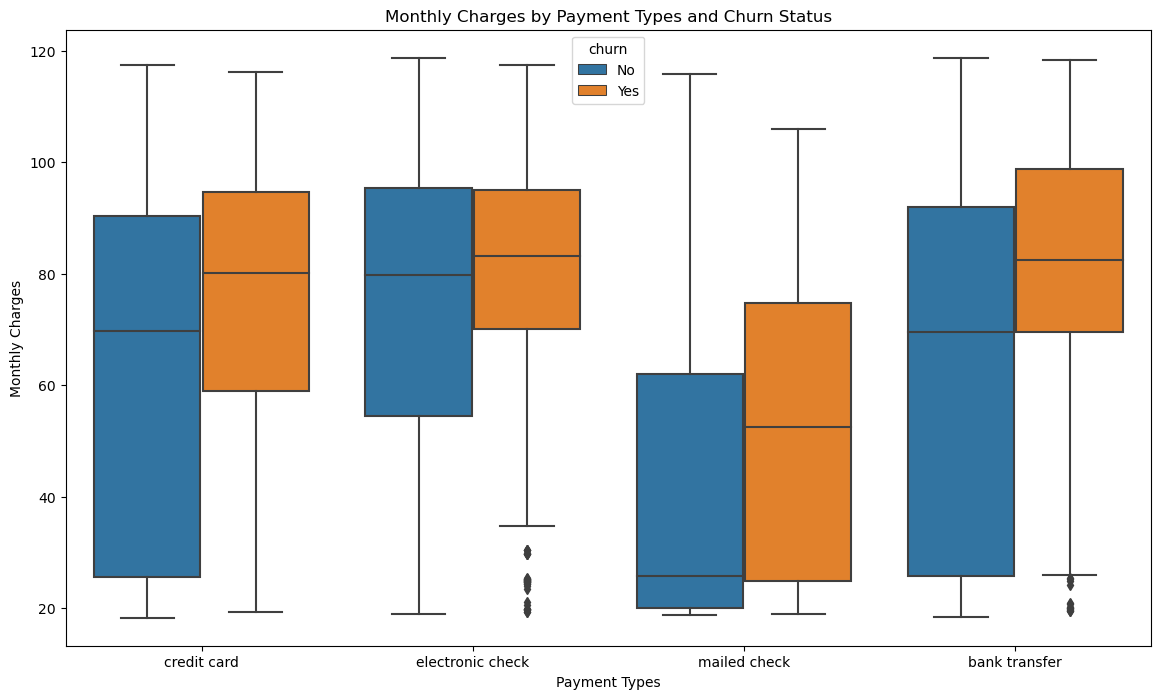

In [93]:
# Create subsets for each combination of contract type and internet service type
subgroups = train.groupby(['payment_type', 'internet_service_type'])

# Visualize the mean monthly charges with hue for churn status using a point plot
plt.figure(figsize=(14, 8))
sns.boxplot(x='payment_type', y='monthly_charges', hue='churn', data=train)
plt.title('Monthly Charges by Payment Types and Churn Status')
plt.xlabel('Payment Types')
plt.ylabel('Monthly Charges')
plt.show()

Conclusions:  Monthly charges is a driver of churn across all contract types but not a driver of churn across internet service types.  Look further into finding drivers of churn in internet service type category.  Monthly charges also appear to be a driver of churn across a majority of payment types.  Look into furhter when have time. 

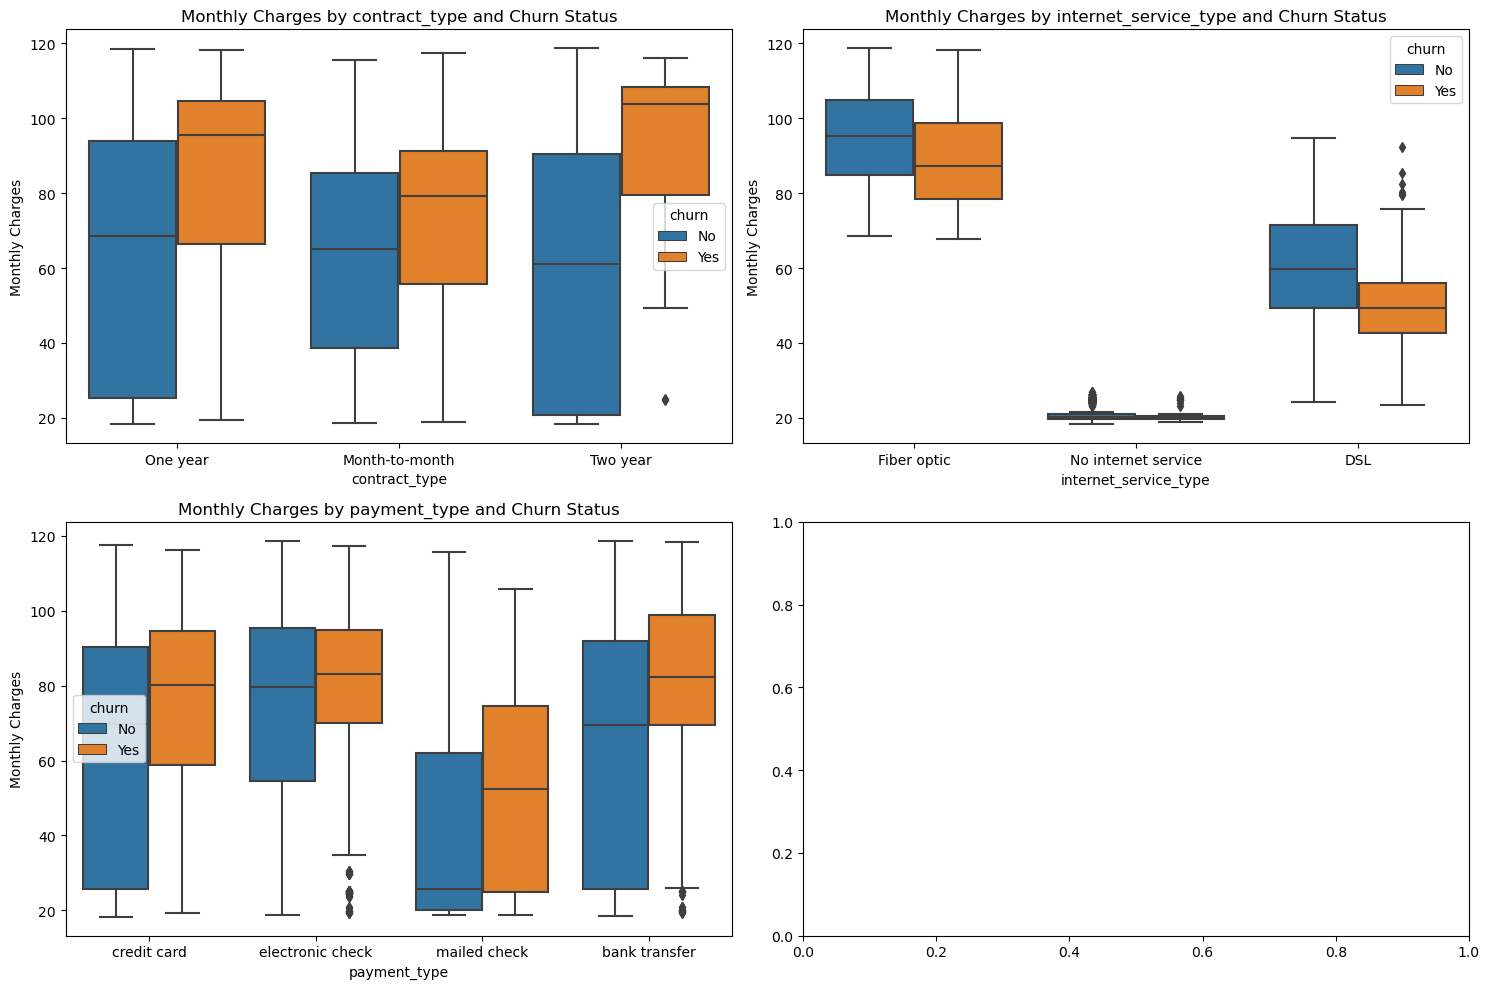

In [94]:
# Create subsets for each combination of contract type, internet service type, and payment type
subgroups = ['contract_type', 'internet_service_type', 'payment_type']

# Get the number of unique combinations for subplot layout
num_subplots = len(subgroups)

# Set up the subplot grid
num_cols = 2  # Number of columns in the subplot grid
num_rows = (num_subplots + 1) // num_cols  # Calculate the number of rows

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Iterate through subgroups and create boxplots
for i, subgroup in enumerate(subgroups):
    sns.boxplot(x=subgroup, y='monthly_charges', hue='churn', data=train, ax=axes[i])
    axes[i].set_title(f'Monthly Charges by {subgroup} and Churn Status')
    axes[i].set_xlabel(subgroup)
    axes[i].set_ylabel('Monthly Charges')

# Adjust layout for better appearance
plt.tight_layout()
plt.show()

Preprocessing Phase

In [96]:
def telco_encoded(train, validate, test):
    '''
    For loops through the train, validate, and test dfs to create an encoded df list.  Encoding skips customer id & total charges.  A key feature being evaluated is monthly charges.  Since monthly charges is a float datatype pd.cut is used to create bins that align with corresponding spikes in churn (increments of 30) and labels are created to show bin range.  If datatype is object gets dummies dropping the first subfeature into 0,0 as true indicator.
    
    Parameters:
    train: Training dataset.
    validate: Validation dataset.
    test: Testing dataset.

    '''
    encoded_dfs = []

    for df in [train, validate, test]:
        df_encoded = df.copy()

        for col in df.columns:
            if col == 'customer_id':
                continue
            if col == 'total_charges':
                continue
            elif df[col].dtype == 'O' or col == 'monthly_charges':
                if col == 'monthly_charges':
                    # Convert 'monthly_charges' to categorical bins before one-hot encoding
                    df_encoded['monthly_charges'] = pd.cut(df_encoded['monthly_charges'], bins=[0, 30, 60, 90, 120, float('inf')], labels=['0-30', '30-60', '60-90', '90-120', '120+'])
                df_dummies = pd.get_dummies(df_encoded[col], prefix=col, drop_first=True).astype(int)
                df_encoded = df_encoded.join(df_dummies).drop(columns=[col])

        encoded_dfs.append(df_encoded)

    return encoded_dfs

In [97]:
train, validate, test=telco_encoded(train, validate, test)

In [190]:
train.head()



,customer_id,senior_citizen,tenure,total_charges,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,...,monthly_charges_90-120,monthly_charges_120+,churn_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_No internet service,payment_type_credit card,payment_type_electronic check,payment_type_mailed check
2865,4083-BFNYK,1,38,3591.25,0,1,0,1,0,1,...,1,0,0,1,0,1,0,1,0,0
4107,5804-LEPIM,1,2,139.05,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,1,0
3453,4895-TMWIR,1,11,214.75,1,1,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
923,1342-JPNKI,0,10,834.10,1,0,0,1,0,1,...,0,0,1,0,0,1,0,0,0,0
2370,3397-AVTKU,0,43,2548.55,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0


In [191]:
def prep_xy(df):
    '''
    Use function to preprocesses train, validate, and test Telco data and returns X and y.  Need to input each 
    separately

    Parameters:
    df: df

    '''
    # List of columns to drop
    columns_to_drop = [
        'churn_Yes', 'customer_id', 'total_charges', 'senior_citizen', 'tenure',
        'gender_Male', 'partner_Yes', 'dependents_Yes', 'phone_service_Yes',
        'multiple_lines_No phone service', 'multiple_lines_Yes',
        'online_security_No internet service', 'online_security_Yes',
        'online_backup_No internet service', 'online_backup_Yes',
        'device_protection_No internet service', 'device_protection_Yes',
        'tech_support_No internet service', 'tech_support_Yes',
        'streaming_tv_No internet service', 'streaming_tv_Yes',
        'streaming_movies_No internet service', 'streaming_movies_Yes',
        'paperless_billing_Yes'
    ]

    # Drop specified columns
    X = df.drop(columns=columns_to_drop)
    y = df['churn_Yes']

    return X, y

In [192]:
X_train, y_train = prep_xy(train)
X_validate, y_validate = prep_xy(validate)
X_test, y_test = prep_xy(test)

In [193]:
y_train.mode()

0    0
Name: churn_Yes, dtype: int64

baseline is no churn


In [194]:
#baseline accuracy
y_train.value_counts(normalize=True)[0]

0.7346745562130178

In [205]:
# Create an instance of DecisionTreeClassifier
dt_model = DecisionTreeClassifier(max_depth=6, random_state=42)

# Fit the model on the training data
dt_model.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=6, random_state=42)

In [206]:
dt_model.feature_names_in_

array(['monthly_charges_30-60', 'monthly_charges_60-90',
       'monthly_charges_90-120', 'monthly_charges_120+',
       'contract_type_One year', 'contract_type_Two year',
       'internet_service_type_Fiber optic',
       'internet_service_type_No internet service',
       'payment_type_credit card', 'payment_type_electronic check',
       'payment_type_mailed check'], dtype=object)

In [207]:
dt_model.classes_

array([0, 1])

In [208]:
# Make predictions on the validation set
y_pred = dt_model.predict(X_train)


In [209]:
accuracy = accuracy_score(y_train, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.77


In [210]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85      3104
           1       0.61      0.43      0.50      1121

    accuracy                           0.77      4225
   macro avg       0.71      0.66      0.68      4225
weighted avg       0.76      0.77      0.76      4225



In [211]:
def decision_tree_model(X_train, y_train, X_validate, y_validate, max_depth_values):
    '''
    Train and evaluate Decision Tree models with different max_depth values on the training and validation data to find optimal
    max depth.

    Parameters:
    X_train: Features for training.
    y_train: Target variable for training.
    X_validate: Features for validation.
    y_validate: Target variable for validation.
    max_depth_values (list): List of max_depth values to try.

    '''
    for max_depth in max_depth_values:
        # Create an instance of DecisionTreeClassifier with the current max_depth
        dt_model = DecisionTreeClassifier(max_depth=max_depth, random_state=42)

        # Fit the model on the training data
        dt_model.fit(X_train, y_train)

        # Make predictions on the training set
        y_pred_train = dt_model.predict(X_train)

        # Make predictions on the validation set
        y_pred_validate = dt_model.predict(X_validate)

        # Print results for the current max_depth
        print(f"\nResults for max_depth={max_depth}:\n")
        print('Classification Report (Training):\n', classification_report(y_train, y_pred_train))
        print('Classification Report (Validation):\n', classification_report(y_validate, y_pred_validate))


In [212]:
max_depth_values = range(1, 11)  # Try max_depth values from 1 to 10
decision_tree_model(X_train, y_train, X_validate, y_validate, max_depth_values)


Results for max_depth=1:

Classification Report (Training):
               precision    recall  f1-score   support

           0       0.73      1.00      0.85      3104
           1       0.00      0.00      0.00      1121

    accuracy                           0.73      4225
   macro avg       0.37      0.50      0.42      4225
weighted avg       0.54      0.73      0.62      4225

Classification Report (Validation):
               precision    recall  f1-score   support

           0       0.73      1.00      0.85      1035
           1       0.00      0.00      0.00       374

    accuracy                           0.73      1409
   macro avg       0.37      0.50      0.42      1409
weighted avg       0.54      0.73      0.62      1409


Results for max_depth=2:

Classification Report (Training):
               precision    recall  f1-score   support

           0       0.81      0.85      0.83      3104
           1       0.53      0.46      0.49      1121

    accuracy         

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/l

max depth of 6 seems optimal across all features accuracy remains constant at 77 and precision peaks in validation at .59

In [213]:
# # Narrow model down to key subfeatures identified in exploration

# # Features to keep
# selected_features = [
#     'internet_service_type_Fiber optic',
#     'payment_type_mailed check',
#     'contract_type_Month to_month',
#     'monthly_charges_30-60', 
#     'monthly_charges_60-90',
#     'monthly_charges_90-120', 
#     'monthly_charges_120+'
# ]


# # Extract the selected features from the datasets
# X_train_selected = X_train[selected_features]
# X_validate_selected = X_validate[selected_features]
# X_test_selected = X_test[selected_features]


# Did not have time to get to :(

In [223]:
# Create an instance of DecisionTreeClassifier with the desired max_depth
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)

# Fit the model on the training data
dt_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = dt_model.predict(X_test)

# Print the classification report
print('Classification Report (Test):\n', classification_report(y_test, y_pred_test))

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.82      0.90      0.85      1035
           1       0.60      0.44      0.51       374

    accuracy                           0.78      1409
   macro avg       0.71      0.67      0.68      1409
weighted avg       0.76      0.78      0.76      1409

